In [2]:
import tensorflow as tf
import tensorflow_datasets
import numpy as np
import pandas as pd
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
print(tf.__version__)
import matplotlib.pyplot as plt
from keras.layers import Dense, MaxPool2D, Conv2D, Input

2.12.0


In [ ]:
(train_data, test_data), ds_info = tensorflow_datasets.load(name = "food101", as_supervised = True, with_info = True, shuffle_files = True,
                                                           split = ["train", "validation"])

In [4]:
#getting the class names from the dataset. In total there are 101 classes
class_names = ds_info.features["label"].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [5]:
training_sample = train_data.take(1)
#unpacking the training sample (contains a tuple of image and)
for image, label in training_sample:
    print(f"""
  Image shape: {image.shape}
  Image dtype: {image.dtype}
  Target class from Food101 (tensor form): {label}
  Class name (str form): {class_names[label.numpy()]}
        """)


  Image shape: (512, 512, 3)
  Image dtype: <dtype: 'uint8'>
  Target class from Food101 (tensor form): 23
  Class name (str form): churros
        


In [6]:
'''thus most of the images are of size 512x512 but some have a smaller size. Also, the images are in the form of tensors where each entry is a pixel data
of type uint8 (ranging from 0 - 255) with 0 corresponding to black and 255 corresponding to white. Also, since we set shuffle_files = True while loading
the dataset, we will get a different dataset each time we take 1 sample from the dataset'''
print(image.shape)
print(image[10,10])
#represents the 10th row and the 10th column in the image
print(tf.reduce_min(image).numpy())   #minimum value - corresponds to black
print(tf.reduce_max(image).numpy())   #corresponds to white


(512, 512, 3)
tf.Tensor([166 140 103], shape=(3,), dtype=uint8)
0
255


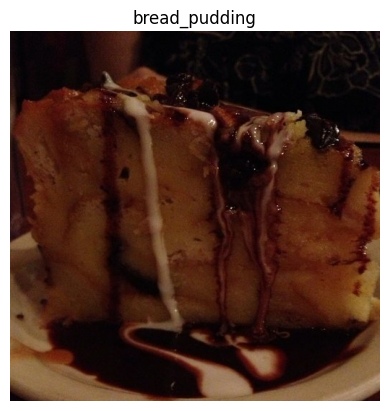

In [ ]:
#plotting an image from the dataset
train_sample = train_data.take(1)
for image, label in train_sample:
    plt.imshow(image)
    plt.title(class_names[label.numpy()])
    plt.axis(False)
    plt.show()

<Figure size 2000x2000 with 0 Axes>

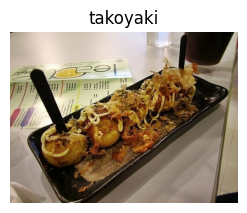

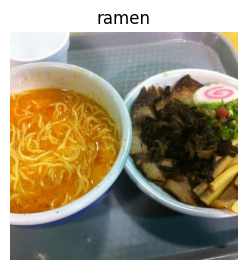

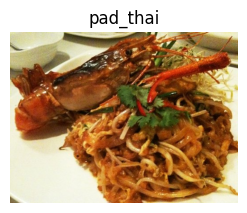

In [ ]:
#creating a function to plot 3 images at once in a rows structure
plt.figure(figsize = (20,20))
def plot_images_from_dataset(data = train_data):
    for i in range(3):
        plt.figure(figsize = (10,7))
        plt.subplot(1,3,i+1)
        training_sample = data.take(1)
        for image, label in training_sample:
            pass
        plt.imshow(image)
        plt.title(class_names[label.numpy()])
        plt.axis(False)
        plt.show()

plot_images_from_dataset(train_data)

### We need to preprocess the images because -
1. Tensorflow likes input tensors to be in float32 format but here, the tensors have data type uint8
2. The images are of different sizes and we need to resize all the images to be of the same size

(224, 224, 3)
<dtype: 'float32'>


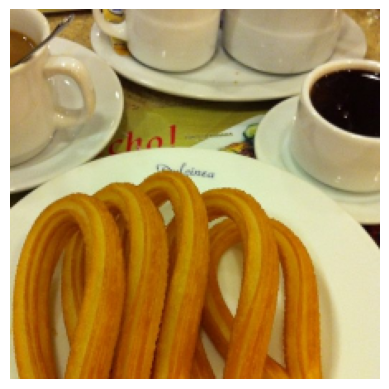

In [7]:
# Make a function for preprocessing images
def preprocess_img(image, label, img_shape=224):
    """
    Converts image datatype from 'uint8' -> 'float32' and reshapes image to
    [img_shape, img_shape, color_channels]
    """
    image = tf.image.resize(image, [img_shape, img_shape]) # reshape to img_shape
    return tf.cast(image, tf.float32), label # return (float32_image, label) tuple

preprocessed_image = preprocess_img(image, label, img_shape = 224)[0]
print(preprocessed_image.shape)
print(preprocessed_image.dtype)
plt.imshow(preprocessed_image/255.0)  #if the data type is float32, then imshow prefers the pixel colour values to be between 0.0 and 1.0.
plt.axis(False)
plt.show()

In [8]:
#applying the aforementioned preprocessing function to the train and test datsets to prepare them for the model
train_data = train_data.map(map_func = preprocess_img, num_parallel_calls = tf.data.AUTOTUNE)
train_data = train_data.shuffle(buffer_size = 1000).batch(batch_size = 32).prefetch(buffer_size = tf.data.AUTOTUNE)
test_data = test_data.map(map_func = preprocess_img, num_parallel_calls = tf.data.AUTOTUNE)
test_data = test_data.shuffle(buffer_size = 1000).batch(batch_size = 32).prefetch(buffer_size = tf.data.AUTOTUNE)

'''
shuffle - shuffles the data in the training and the test datasets
.batch(buffer_size = 32) - creates batches of size 32 of the dataset so that the mini train data (also called a mini batch) can fit in the GPU memory
.prefetch() - prefetches the next batch before the model finishes working on the previous batch. The next batch should be prepared as the model
              finishes working on the first batch of the dataset. Tensorflow manages this using AUTOTUNE feature and manages compute resources accordingly'''


'\nshuffle - shuffles the data in the training and the test datasets\n.batch(buffer_size = 32) - creates batches of size 32 of the dataset so that the mini train data (also called a mini batch) can fit in the GPU memory\n.prefetch() - prefetches the next batch before the model finishes working on the previous batch. The next batch should be prepared as the model\n              finishes working on the first batch of the dataset. Tensorflow manages this using AUTOTUNE feature and manages compute resources accordingly'

In [9]:
print("Number of batches on the training data : {}".format(len(train_data)))
print("Number of batches on the test data : {}".format(len(test_data)))
#training data has 2368 batches of 32 images each (the last batch might contain a smaller number of images (remainder))

Number of batches on the training data : 2368
Number of batches on the test data : 790


In [10]:
#creating a function to create modelcheckpoint callback
def create_model_checkpoint(checkpoint_path):
    '''
    monitor = val_loss (monitors the validation loss and uses the lowest validation loss to store the weights)
    save_weights_only = only saves the weigths of the layers instead of saving the entire model so as to save memory
    save_best_only = instead of saving the weights at every epoch (default frequency), stores the best weights only (which result in lowest val_loss)'''
    checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath = checkpoint_path, monitor = "val_loss", save_weights_only = True,
                                                   save_best_only = True, verbose = 0)
    return checkpoint_callback


In [11]:
#setting up mixed precision training so as to improve the training times
from keras import mixed_precision
mixed_precision.set_global_policy(policy="mixed_float16")

In [ ]:
#using transfer learning to make predictions
base_model = tf.keras.applications.EfficientNetB7(include_top = False)
base_model.trainable = False

#first, without using data augmentation
inputs = Input(shape = (224,224,3))
x = base_model(inputs, training = False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = Dense(1024, activation = "relu")(x)
x = Dense(1024, activation = "relu")(x)
x = Dense(101)(x)
outputs = tf.keras.layers.Activation("softmax", dtype = tf.float32)(x)

model_EFNB7 = tf.keras.Model(inputs, outputs)
model_EFNB7.compile(optimizer = tf.keras.optimizers.Adam(), loss = tf.keras.losses.SparseCategoricalCrossentropy(), metrics = "accuracy")
history = model_EFNB7.fit(train_data, epochs = 10, steps_per_epoch = len(train_data), validation_data = test_data, validation_steps =
                          int(0.5*len(test_data)))


Epoch 1/10

2368/2368 [==============================] - 569s 229ms/step - loss: 1.8855 - accuracy: 0.5180 - val_loss: 1.3925 - val_accuracy: 0.6307

Epoch 2/10

2368/2368 [==============================] - 531s 223ms/step - loss: 1.3518 - accuracy: 0.6408 - val_loss: 1.3294 - val_accuracy: 0.6482

Epoch 3/10

2368/2368 [==============================] - 540s 226ms/step - loss: 1.0823 - accuracy: 0.7009 - val_loss: 1.3778 - val_accuracy: 0.6517

Epoch 4/10

2368/2368 [==============================] - 529s 222ms/step - loss: 0.8497 - accuracy: 0.7553 - val_loss: 1.4189 - val_accuracy: 0.6597

Epoch 5/10

2368/2368 [==============================] - 530s 222ms/step - loss: 0.6528 - accuracy: 0.8060 - val_loss: 1.5931 - val_accuracy: 0.6490

Epoch 6/10

2368/2368 [==============================] - 530s 223ms/step - loss: 0.5205 - accuracy: 0.8418 - val_loss: 1.7127 - val_accuracy: 0.6578

Epoch 7/10

2368/2368 [==============================] - 529s 222ms/step - loss: 0.4157 - accuracy: 

In [ ]:
#using transfer learning to make predictions
base_model = tf.keras.applications.ResNet50(include_top = False)
base_model.trainable = False

#first, without using data augmentation
inputs = Input(shape = (224,224,3))
x = base_model(inputs, training = False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = Dense(1024, activation = "relu")(x)
x = Dense(1024, activation = "relu")(x)
x = Dense(101)(x)
outputs = tf.keras.layers.Activation("softmax", dtype = tf.float32)(x)

model_EFNB7 = tf.keras.Model(inputs, outputs)
model_EFNB7.compile(optimizer = tf.keras.optimizers.Adam(), loss = tf.keras.losses.SparseCategoricalCrossentropy(), metrics = "accuracy")
history = model_EFNB7.fit(train_data, epochs = 6, steps_per_epoch = len(train_data), validation_data = test_data, validation_steps =
                          int(0.5*len(test_data)))



94765736/94765736 [==============================] - 3s 0us/step

Epoch 1/6

2368/2368 [==============================] - 234s 95ms/step - loss: 2.5601 - accuracy: 0.3712 - val_loss: 2.0320 - val_accuracy: 0.4738

Epoch 2/6

2368/2368 [==============================] - 211s 88ms/step - loss: 2.0250 - accuracy: 0.4838 - val_loss: 1.9210 - val_accuracy: 0.5019

Epoch 3/6

2368/2368 [==============================] - 206s 86ms/step - loss: 1.8067 - accuracy: 0.5313 - val_loss: 1.8401 - val_accuracy: 0.5301

Epoch 4/6

2368/2368 [==============================] - 210s 88ms/step - loss: 1.6565 - accuracy: 0.5646 - val_loss: 1.8538 - val_accuracy: 0.5286

Epoch 5/6

2368/2368 [==============================] - 220s 92ms/step - loss: 1.5133 - accuracy: 0.5952 - val_loss: 1.8926 - val_accuracy: 0.5308

Epoch 6/6

2368/2368 [==============================] - 220s 92ms/step - loss: 1.3976 - accuracy: 0.6212 - val_loss: 1.9186 - val_accuracy: 0.5378


In [ ]:
history = model_EFNB7.fit(train_data, epochs = 6, steps_per_epoch = len(train_data), validation_data = test_data, validation_steps =
                          int(0.5*len(test_data)))

Epoch 1/6

2368/2368 [==============================] - 207s 87ms/step - loss: 1.2736 - accuracy: 0.6484 - val_loss: 2.0389 - val_accuracy: 0.5307

Epoch 2/6

2368/2368 [==============================] - 210s 86ms/step - loss: 1.1688 - accuracy: 0.6743 - val_loss: 2.1376 - val_accuracy: 0.5271

Epoch 3/6

2368/2368 [==============================] - 212s 87ms/step - loss: 1.0748 - accuracy: 0.6954 - val_loss: 2.3358 - val_accuracy: 0.5152

Epoch 4/6

2368/2368 [==============================] - 225s 93ms/step - loss: 0.9885 - accuracy: 0.7177 - val_loss: 2.3866 - val_accuracy: 0.5134

Epoch 5/6

2368/2368 [==============================] - 216s 89ms/step - loss: 0.9113 - accuracy: 0.7380 - val_loss: 2.5165 - val_accuracy: 0.5185

Epoch 6/6

2368/2368 [==============================] - 223s 92ms/step - loss: 0.8463 - accuracy: 0.7540 - val_loss: 2.8009 - val_accuracy: 0.5119


In [ ]:
#As we can see, the efficient net model works much better (even though it takes more time to train). Thus, we try fine tuning the efficient net model
#and, we can try using EfficientNetB3 instead of B7 to speed up training (as it is less complex)

In [12]:
base_model = tf.keras.applications.EfficientNetB3(include_top = False)
base_model.trainable = False

#without using data augmentation first
inputs = Input(shape = (224,224,3))
x = base_model(inputs, training = False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = Dense(1024, activation = "relu")(x)
x = Dense(1024, activation = "relu")(x)
x = Dense(101)(x)
outputs = tf.keras.layers.Activation("softmax", dtype = tf.float32)(x)

#creating a checkpoint callbacks
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath = "Tensorflow Checkpoints/EfficientNetB3/model.chkpt",
                                                         save_weights_only = True, save_best_only = True)

model_EFNB3 = tf.keras.Model(inputs, outputs)
model_EFNB3.compile(optimizer = tf.keras.optimizers.Adam(), loss = tf.keras.losses.SparseCategoricalCrossentropy(), metrics = "accuracy")
history = model_EFNB3.fit(train_data, epochs = 6, steps_per_epoch = len(train_data), validation_data = test_data, validation_steps =
                          int(0.5*len(test_data)), callbacks = checkpoint_callback)

43941136/43941136 [==============================] - 0s 0us/step
Epoch 1/6
2368/2368 [==============================] - 262s 101ms/step - loss: 1.7405 - accuracy: 0.5540 - val_loss: 1.2725 - val_accuracy: 0.6567
Epoch 2/6
2368/2368 [==============================] - 224s 94ms/step - loss: 1.1882 - accuracy: 0.6789 - val_loss: 1.2318 - val_accuracy: 0.6762
Epoch 3/6
2368/2368 [==============================] - 254s 106ms/step - loss: 0.8631 - accuracy: 0.7554 - val_loss: 1.2578 - val_accuracy: 0.6798
Epoch 4/6
2368/2368 [==============================] - 243s 101ms/step - loss: 0.5966 - accuracy: 0.8211 - val_loss: 1.4030 - val_accuracy: 0.6772
Epoch 5/6
2368/2368 [==============================] - 220s 92ms/step - loss: 0.4166 - accuracy: 0.8707 - val_loss: 1.6200 - val_accuracy: 0.6725
Epoch 6/6
2368/2368 [==============================] - 238s 99ms/step - loss: 0.3176 - accuracy: 0.8997 - val_loss: 1.8747 - val_accuracy: 0.6748


In [16]:
model_EFNB3.load_weights("Tensorflow Checkpoints/EfficientNetB3/model.chkpt")  #loading the best weights and we go on from there

In [17]:
model_EFNB3.evaluate(test_data)

790/790 [==============================] - 64s 78ms/step - loss: 1.2372 - accuracy: 0.6763


[1.237162709236145, 0.6763168573379517]

In [18]:
#Fine tuning the model
#allowing the last 30 layers to be trainable
base_model.trainable = True
for layer in base_model.layers[:-20]:
  layer.trainable = False


In [19]:
#recompiling the model to reset the state of the optimizer function
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath = "Tensorflow Checkpoints/EfficientNetB3/model.chkpt",
                                                         save_weights_only = True, save_best_only = True, monitor = "val_accuracy")

model_EFNB3.compile(optimizer = tf.keras.optimizers.Adam(0.0001), loss = tf.keras.losses.SparseCategoricalCrossentropy(), metrics = "accuracy")
history = model_EFNB3.fit(train_data, epochs = 12, steps_per_epoch = len(train_data), validation_data = test_data, validation_steps =
                          int(0.5*len(test_data)), callbacks = checkpoint_callback, initial_epoch = history.epoch[-1])

Epoch 6/12
2368/2368 [==============================] - 253s 98ms/step - loss: 0.6618 - accuracy: 0.8105 - val_loss: 1.0344 - val_accuracy: 0.7255
Epoch 7/12
2368/2368 [==============================] - 237s 99ms/step - loss: 0.3666 - accuracy: 0.8931 - val_loss: 1.1109 - val_accuracy: 0.7312
Epoch 8/12
2368/2368 [==============================] - 228s 95ms/step - loss: 0.1932 - accuracy: 0.9455 - val_loss: 1.2715 - val_accuracy: 0.7309
Epoch 9/12
2368/2368 [==============================] - 227s 95ms/step - loss: 0.1067 - accuracy: 0.9698 - val_loss: 1.3708 - val_accuracy: 0.7291
Epoch 10/12
2368/2368 [==============================] - 228s 95ms/step - loss: 0.0666 - accuracy: 0.9820 - val_loss: 1.4806 - val_accuracy: 0.7271
Epoch 11/12
2368/2368 [==============================] - 229s 96ms/step - loss: 0.0534 - accuracy: 0.9853 - val_loss: 1.5624 - val_accuracy: 0.7263
Epoch 12/12
2368/2368 [==============================] - 240s 100ms/step - loss: 0.0429 - accuracy: 0.9882 - val_los

In [20]:
model_EFNB3.evaluate(test_data)

790/790 [==============================] - 62s 76ms/step - loss: 1.5935 - accuracy: 0.7304


[1.593489170074463, 0.7304158210754395]

## The Fine tuned model (without data augmentation) achieved an accuracy of 73.04% on the entire test data. This is much better than the deepfood paper with just 50.76 percent accuracy

In [ ]:
#Now using data augmentation, we again train the same model and check whether performance improves or not

from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomHeight, RandomWidth, RandomZoom, RandomRotation
data_augment = tf.keras.Sequential()
data_augment.add(RandomFlip("horizontal"))
data_augment.add(RandomHeight(0.2))
data_augment.add(RandomWidth(0.2))
data_augment.add(RandomZoom(0.2))
data_augment.add(RandomRotation(0.2))

base_model = tf.keras.applications.EfficientNetB3(include_top = False)
base_model.trainable = False

#without using data augmentation first
inputs = Input(shape = (224,224,3))
x = data_augment(inputs, training = True)
x = base_model(x, training = False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = Dense(1024, activation = "relu")(x)
x = Dense(1024, activation = "relu")(x)
x = Dense(101)(x)
outputs = tf.keras.layers.Activation("softmax", dtype = tf.float32)(x)

#creating a checkpoint callbacks
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath = "Tensorflow Checkpoints/EfficientNetB3 Augmented/model.chkpt",
                                                         save_weights_only = True, save_best_only = True, monitor = "val_accuracy")

model_EFNB3_augment = tf.keras.Model(inputs, outputs)
model_EFNB3_augment.compile(optimizer = tf.keras.optimizers.Adam(), loss = tf.keras.losses.SparseCategoricalCrossentropy(), metrics = "accuracy")
history_augment = model_EFNB3_augment.fit(train_data, epochs = 6, steps_per_epoch = len(train_data), validation_data = test_data, validation_steps =
                          int(0.25*len(test_data)), callbacks = checkpoint_callback)


Epoch 1/6

2368/2368 [==============================] - 655s 266ms/step - loss: 2.1449 - accuracy: 0.4650 - val_loss: 1.6980 - val_accuracy: 0.5539

Epoch 2/6

2368/2368 [==============================] - 439s 184ms/step - loss: 1.7299 - accuracy: 0.5554 - val_loss: 1.5437 - val_accuracy: 0.5938

Epoch 3/6

2368/2368 [==============================] - 364s 153ms/step - loss: 1.5848 - accuracy: 0.5870 - val_loss: 1.5310 - val_accuracy: 0.6031

Epoch 4/6

2368/2368 [==============================] - 325s 136ms/step - loss: 1.4749 - accuracy: 0.6126 - val_loss: 1.5360 - val_accuracy: 0.5999

Epoch 5/6

2368/2368 [==============================] - ETA: 0s - loss: 1.4035 - accuracy: 0.6285

In [ ]:
#using fine tuning
base_model.trainable = True
for layer in base_model.layers[:-30]:
  layer.trainable = False

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath = "Tensorflow Checkpoints/EfficientNetB3 Augmented/model.chkpt",
                                                         save_weights_only = True, save_best_only = True, monitor = "val_accuracy")

model_EFNB3_augment.compile(optimizer = tf.keras.optimizers.Adam(0.0001), loss = tf.keras.losses.SparseCategoricalCrossentropy(), metrics = "accuracy")
history_augment = model_EFNB3_augment.fit(train_data, epochs = 15, steps_per_epoch = len(train_data), validation_data = test_data, validation_steps =
                          int(0.5*len(test_data)), callbacks = checkpoint_callback, initial_epoch = history_augment.epoch[-1])


# Lets try beating the original paper with just **10 percent of the data** used for the original Food101 paper.

In [27]:
import zipfile
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
zip_ref = zipfile.ZipFile("101_food_classes_10_percent.zip")
zip_ref.extractall()
zip_ref.close()

--2023-07-12 16:10:48--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.162.128, 74.125.31.128, 142.250.97.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.162.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip.1’

101_food_classes_10 100%[===================>]   1.51G   123MB/s    in 13s     

2023-07-12 16:11:01 (119 MB/s) - ‘101_food_classes_10_percent.zip.1’ saved [1625420029/1625420029]



In [28]:
# Common library imports
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow_hub as hub
import sklearn
import random

In [29]:
train_data = tf.keras.preprocessing.image_dataset_from_directory(directory = "101_food_classes_10_percent/train", label_mode = "categorical",
                                                                 batch_size = 32, image_size = (224,224), shuffle = True)
test_data = tf.keras.preprocessing.image_dataset_from_directory(directory = "101_food_classes_10_percent/test", label_mode = "categorical",
                                                                batch_size = 32, image_size = (224,224), shuffle = False)
# Now we have the dataset

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


In [30]:
#creating a checkpoint callback to save the model weights
checkpoint_directory = "Tensorflow_checkpoints/101_food_classes_10_percent.chkpt"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath = checkpoint_directory, save_best_only = True, save_weights_only = True,
                                                         save_freq = "epoch", monitor = "val_accuracy")  #will only save epoch with best validation acc
#Also creating a data augmentation layer to incorporate data augmentation into the model itself for faster execution
data_augment = tf.keras.Sequential()
data_augment.add(tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"))
data_augment.add(tf.keras.layers.experimental.preprocessing.RandomZoom(0.2))
data_augment.add(tf.keras.layers.experimental.preprocessing.RandomHeight(0.2))
data_augment.add(tf.keras.layers.experimental.preprocessing.RandomWidth(0.2))
data_augment.add(tf.keras.layers.experimental.preprocessing.RandomRotation(0.2))


Epoch 1/10
237/237 [==============================] - 163s 646ms/step - loss: 3.3676 - accuracy: 0.2754 - val_loss: 2.5520 - val_accuracy: 0.4187
Epoch 2/10
237/237 [==============================] - 128s 541ms/step - loss: 2.2058 - accuracy: 0.4937 - val_loss: 2.1535 - val_accuracy: 0.4841
Epoch 3/10
237/237 [==============================] - 99s 415ms/step - loss: 1.8444 - accuracy: 0.5593 - val_loss: 1.9663 - val_accuracy: 0.5134
Epoch 4/10
237/237 [==============================] - 89s 374ms/step - loss: 1.6327 - accuracy: 0.6013 - val_loss: 1.9205 - val_accuracy: 0.5112
Epoch 5/10
237/237 [==============================] - 113s 476ms/step - loss: 1.4758 - accuracy: 0.6351 - val_loss: 1.8497 - val_accuracy: 0.5287
Epoch 6/10
237/237 [==============================] - 71s 299ms/step - loss: 1.3710 - accuracy: 0.6601 - val_loss: 1.8212 - val_accuracy: 0.5317
Epoch 7/10
237/237 [==============================] - 68s 286ms/step - loss: 1.2594 - accuracy: 0.6904 - val_loss: 1.8152 - val

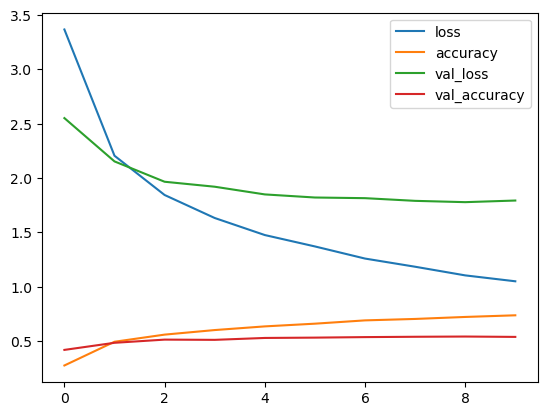

In [31]:
# Creating a feature extraction model using EfficientNetB0 and the functional API
base_model = tf.keras.applications.EfficientNetB0(include_top = False)
base_model.trainable = False
#creating an input layer
inputs = tf.keras.layers.Input(shape = (224,224,3))
#passing the inputs through the data augmentation layer
x = data_augment(inputs, training = True)  #only done during training, data_augmentation is usually not done while evaluating
x = base_model(x, training = False)  #passing augmented inputs through the base model
x = tf.keras.layers.GlobalAveragePooling2D()(x)
#passing the extracted features to the output layer with softmax activation
outputs = tf.keras.layers.Dense(101, activation = "softmax")(x)
model = tf.keras.Model(inputs, outputs)
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), loss = tf.keras.losses.CategoricalCrossentropy(), metrics ="accuracy")
history_without_tuning = model.fit(train_data, epochs = 10, steps_per_epoch = len(train_data), validation_data = test_data,
                                   validation_steps = int(0.5*len(test_data)), callbacks = checkpoint_callback)
pd.DataFrame(history_without_tuning.history).plot()
plt.show()

In [32]:
model.evaluate(test_data)    #while training, we only evaluated on 50 percent data to speed up execution time. Now we evaluate on the entire test dataset

790/790 [==============================] - 79s 100ms/step - loss: 1.7110 - accuracy: 0.5545


[1.7109605073928833, 0.5545346736907959]

Epoch 10/15
237/237 [==============================] - 67s 238ms/step - loss: 0.8688 - accuracy: 0.7659 - val_loss: 1.8246 - val_accuracy: 0.5451
Epoch 11/15
237/237 [==============================] - 63s 265ms/step - loss: 0.7664 - accuracy: 0.7901 - val_loss: 1.8126 - val_accuracy: 0.5552
Epoch 12/15
237/237 [==============================] - 53s 222ms/step - loss: 0.6962 - accuracy: 0.8107 - val_loss: 1.8731 - val_accuracy: 0.5445
Epoch 13/15
237/237 [==============================] - 52s 218ms/step - loss: 0.6433 - accuracy: 0.8227 - val_loss: 1.8499 - val_accuracy: 0.5536
Epoch 14/15
237/237 [==============================] - 51s 215ms/step - loss: 0.5825 - accuracy: 0.8407 - val_loss: 1.8829 - val_accuracy: 0.5491
Epoch 15/15
237/237 [==============================] - 62s 258ms/step - loss: 0.5575 - accuracy: 0.8457 - val_loss: 1.8368 - val_accuracy: 0.5574


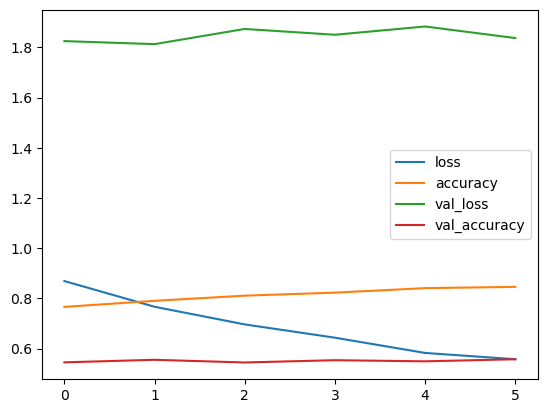

In [33]:
#fine tuning the model to capture the features in the dataset better
#unfreezing some of the layers for fine tuning
base_model.trainable = True
for layer in base_model.layers[:-10]:
  layer.trainable = False         #making all except the last 10 layers non trainable

#we need to recompile the model in such a case
#creating a checkpoint callback
checkpoint_directory = "Tensorflow_checkpoints/101_food_classes_10_percent_fine_tune.chkpt"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath = checkpoint_directory, save_best_only = True, save_weights_only = True,
                                                         save_freq = "epoch", monitor = "val_accuracy" )
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001), loss = tf.keras.losses.CategoricalCrossentropy(), metrics = "accuracy")
history_finetune = model.fit(train_data, epochs = 15, steps_per_epoch = len(train_data), validation_data = test_data,
                             validation_steps = int(0.5*len(test_data)), callbacks = checkpoint_callback,initial_epoch = history_without_tuning.epoch[-1])
pd.DataFrame(history_finetune.history).plot()
plt.show()

In [34]:
pred_prob = model.predict(test_data)
print(len(pred_prob))
print(pred_prob.shape)
print(pred_prob[0])
print(pred_prob[0].argmax())
print(test_data.class_names[29])

790/790 [==============================] - 69s 85ms/step
25250
(25250, 101)
[3.5309e-02 2.3890e-04 2.5040e-02 4.1723e-07 7.7486e-07 2.5034e-06
 4.1914e-04 2.8074e-05 1.5305e-02 5.7316e-04 5.9605e-07 6.4790e-05
 1.2512e-03 2.3842e-07 2.0278e-04 3.4027e-03 8.9288e-05 4.1842e-05
 2.7939e-02 1.9193e-04 1.1215e-03 6.3300e-05 2.4462e-04 2.2089e-04
 2.5082e-03 1.3292e-04 2.4259e-04 1.0598e-04 1.8539e-02 1.1311e-03
 1.3113e-06 3.3226e-03 1.1597e-02 5.3644e-07 6.1621e-01 2.1517e-05
 4.7803e-05 6.5422e-04 4.6783e-02 3.4690e-05 1.5697e-03 3.4561e-03
 3.8171e-04 6.2466e-04 4.4990e-04 1.0214e-03 1.1641e-04 8.6689e-04
 2.8014e-06 1.8906e-02 3.3426e-04 9.8228e-04 2.9968e-02 1.4410e-03
 5.8532e-05 4.3941e-04 2.3804e-02 2.1756e-04 5.3940e-03 6.8545e-06
 5.9605e-08 1.9836e-03 2.0355e-02 1.1578e-03 3.0975e-03 1.0192e-04
 5.8055e-05 4.1351e-03 4.9515e-03 7.4565e-05 2.3699e-04 2.0564e-05
 2.2488e-03 9.1791e-06 4.9710e-05 1.2517e-06 7.9989e-05 1.9236e-03
 2.1577e-04 2.8312e-05 5.0592e-04 4.2248e-04 1.3533e-

In [35]:
#we can take the maximum for each such training example
pred_index = tf.argmax(pred_prob, axis =1)
print(pred_index[:10])
#and now we can assign each class its class label by
pred_class = []
for index in pred_index:
  pred_class.append(test_data.class_names[index])
pred_class = np.array(pred_class)
print(len(pred_prob))

tf.Tensor([34  0 81 38 87 78 29 46  2  0], shape=(10,), dtype=int64)
25250


In [36]:
print(pred_class[:10]) #thus, we have received the class label for rach test example

['eggs_benedict' 'apple_pie' 'ramen' 'fish_and_chips' 'scallops' 'poutine'
 'cup_cakes' 'garlic_bread' 'baklava' 'apple_pie']


In [37]:
#We can do the same for the actual data
y_labels = []
for images,labels in test_data.unbatch():
  y_labels.append(labels.numpy().argmax())
print(y_labels[:10])   #since the images are in order of the folder they are in, the first few images would be label 0, then 1,2,....
#this is because we had made shuffle = False while creating the test_data dataset

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [38]:
from sklearn.metrics import confusion_matrix
y_test = np.array(y_labels)
y_pred = pred_index.numpy()
label_names = test_data.class_names
print(len(pred_prob))

25250


In [39]:
import itertools
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=13, norm=False, savefig=False):
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.
  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.
  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).

  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.
  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])

  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes),
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)

  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()
  plt.xticks(rotation = 75)

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

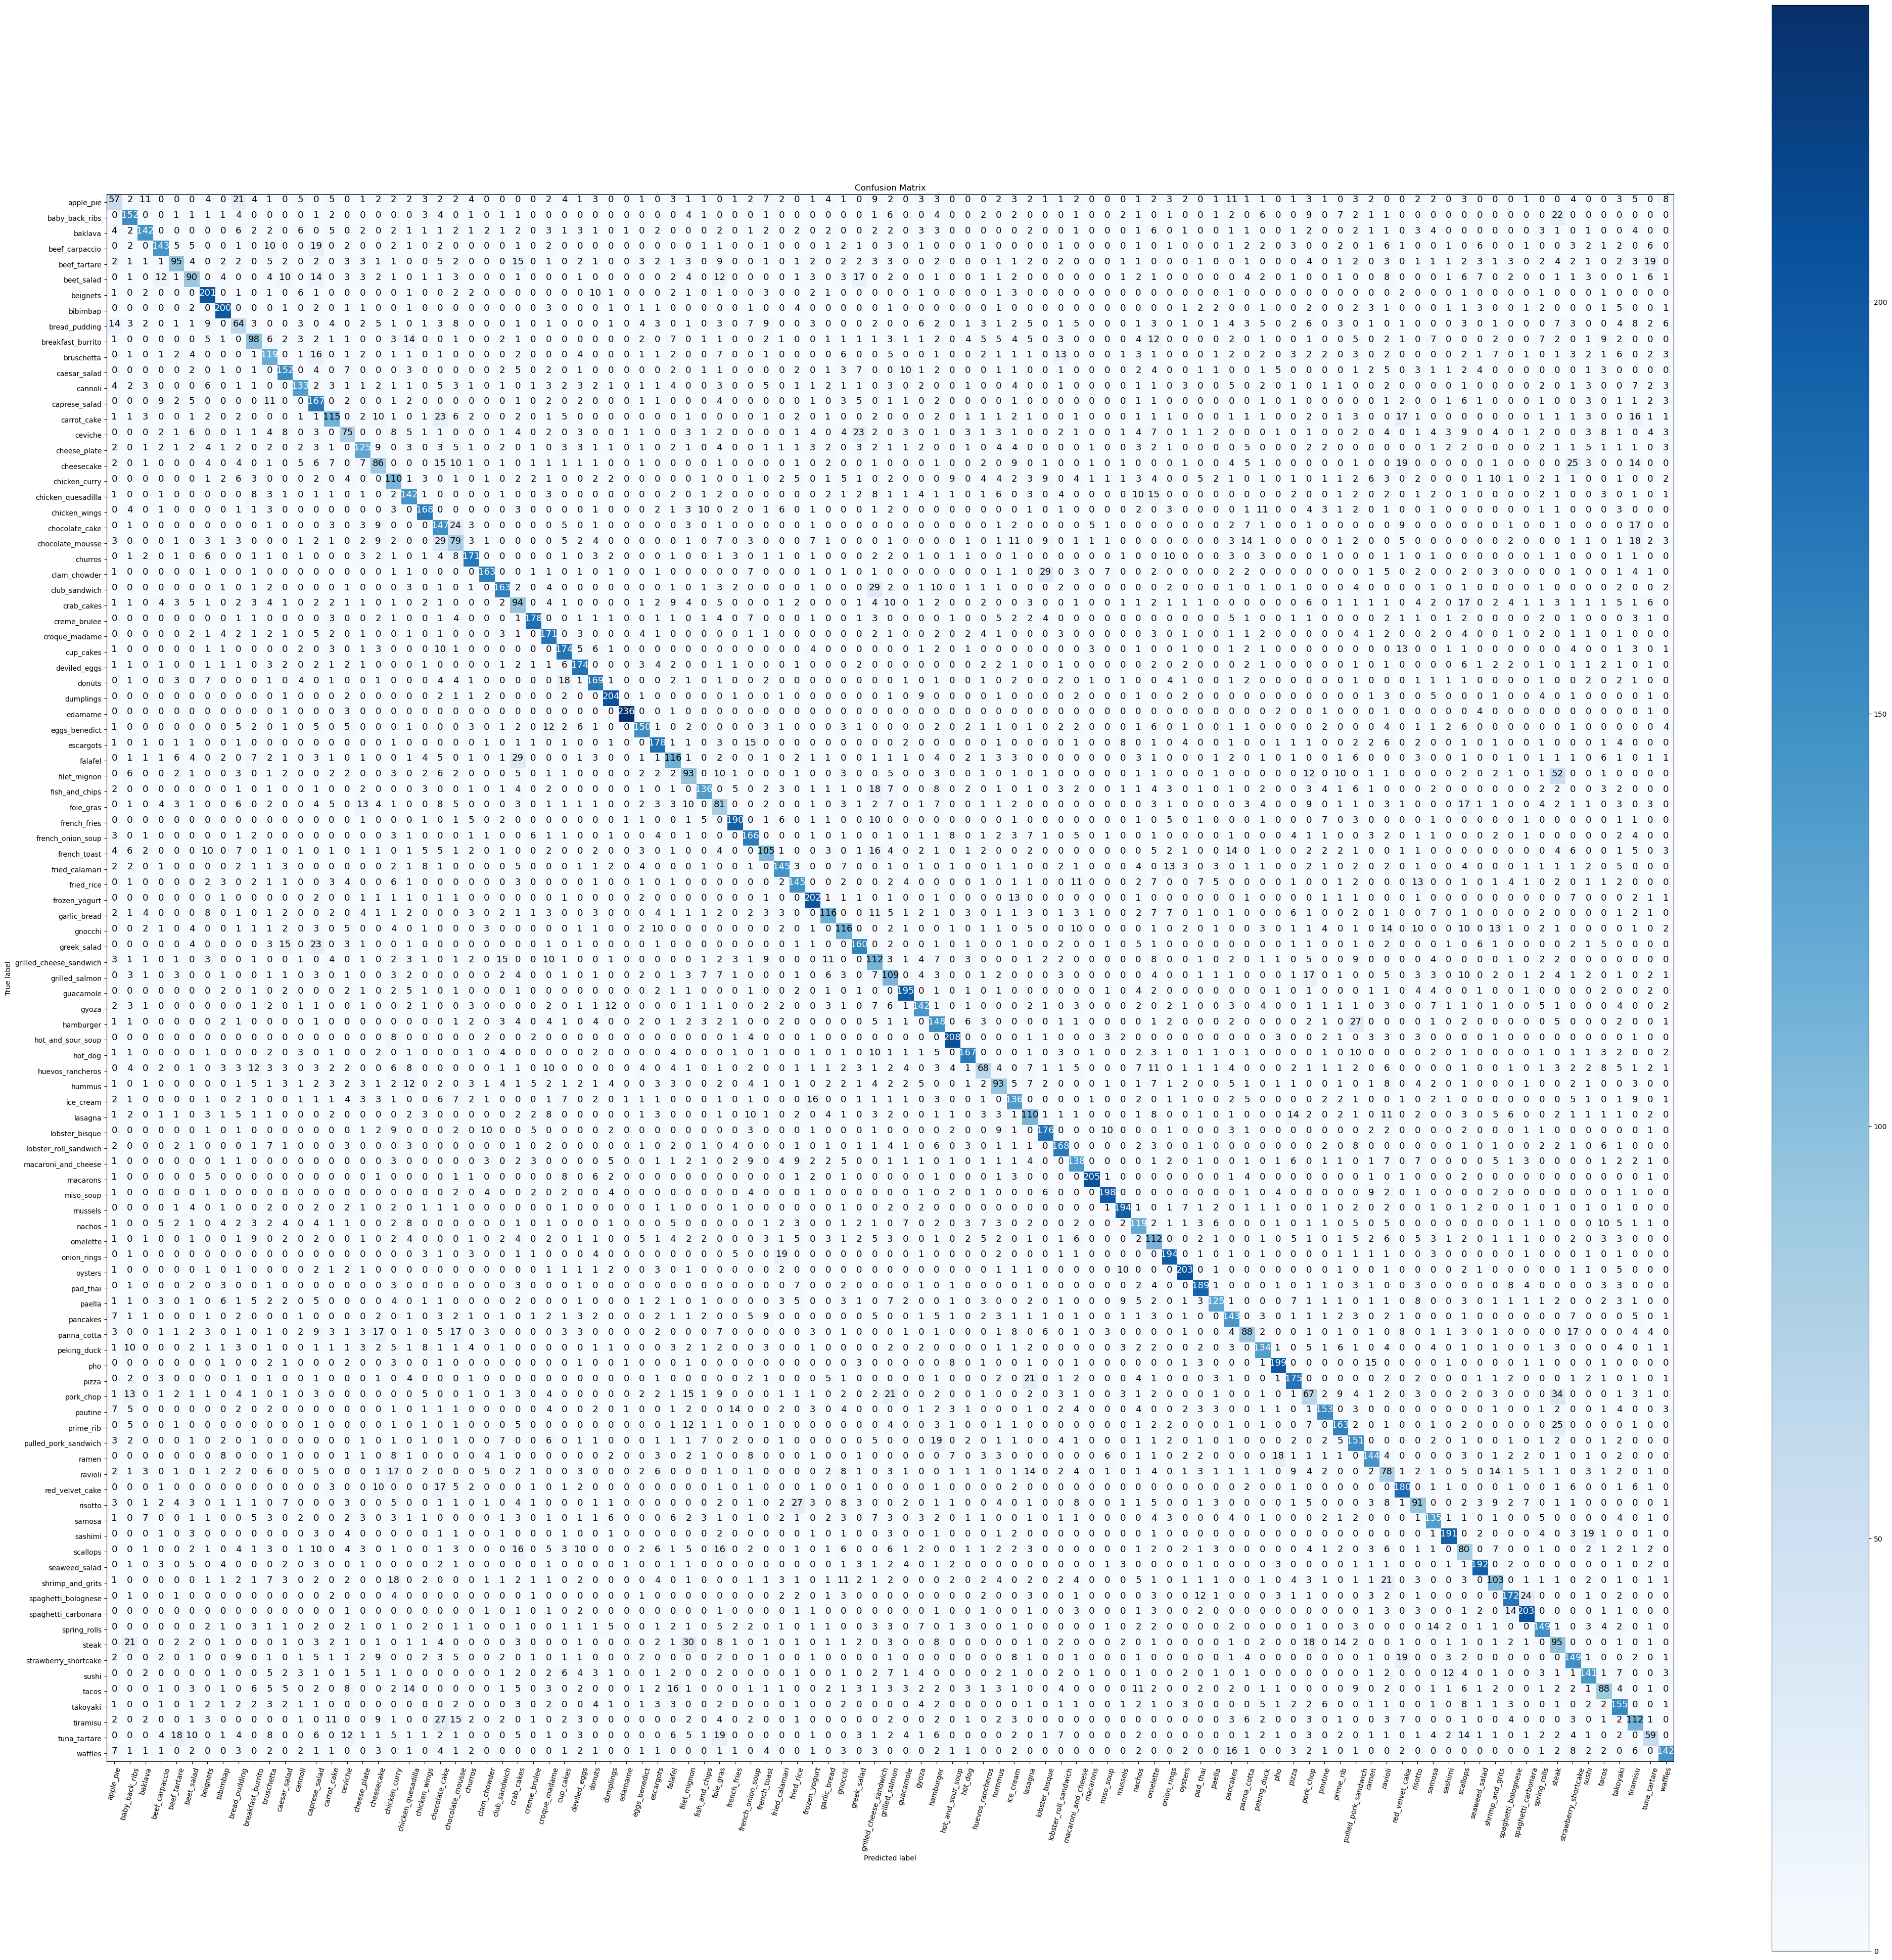

In [40]:
make_confusion_matrix(y_true = y_labels, y_pred =pred_index, classes = label_names, figsize =(50,50))

In [41]:
from sklearn.metrics import classification_report
print(classification_report(y_true = y_labels, y_pred =pred_index))
print(len(pred_prob))
#Creating a dictionary of the classification report
classification_dict = classification_report(y_true = y_labels, y_pred = pred_index, output_dict=True)
#the class names (0,1,2...) are the keys and the F1 score, recall and precision are the entries for each label
print(classification_dict["0"]["precision"])

              precision    recall  f1-score   support

           0       0.33      0.23      0.27       250
           1       0.55      0.61      0.58       250
           2       0.70      0.57      0.63       250
           3       0.66      0.57      0.61       250
           4       0.56      0.38      0.45       250
           5       0.46      0.36      0.40       250
           6       0.65      0.80      0.72       250
           7       0.72      0.80      0.76       250
           8       0.30      0.26      0.28       250
           9       0.47      0.39      0.43       250
          10       0.43      0.48      0.45       250
          11       0.60      0.61      0.60       250
          12       0.68      0.53      0.60       250
          13       0.44      0.67      0.53       250
          14       0.54      0.46      0.50       250
          15       0.39      0.30      0.34       250
          16       0.56      0.50      0.53       250
          17       0.40    

In [42]:
classification_dict["12"]

{'precision': 0.6820512820512821,
 'recall': 0.532,
 'f1-score': 0.597752808988764,
 'support': 250}

In [43]:
label_names
print(len(pred_prob))

25250


In [44]:
#Creating multiple dictionaries for f1 score, precision, recall
class_f1_scores = {}
class_precision = {}
class_recall = {}
for key, value in classification_dict.items():
  if key == "accuracy": break
  else:
    class_f1_scores[label_names[int(key)]] = value["f1-score"]
    class_precision[label_names[int(key)]] = value["precision"]
    class_recall[label_names[int(key)]] = value["recall"]

In [45]:
#Now we have to make a dataframe out of this dictionary
f1_scores = pd.DataFrame({"class_names":list(class_f1_scores.keys()),
                          "F1 Score":list(class_f1_scores.values())}).sort_values("F1 Score", ascending = False)
#Through this, we get the F1 scores for different classes in ascending order
print(len(pred_prob))

25250


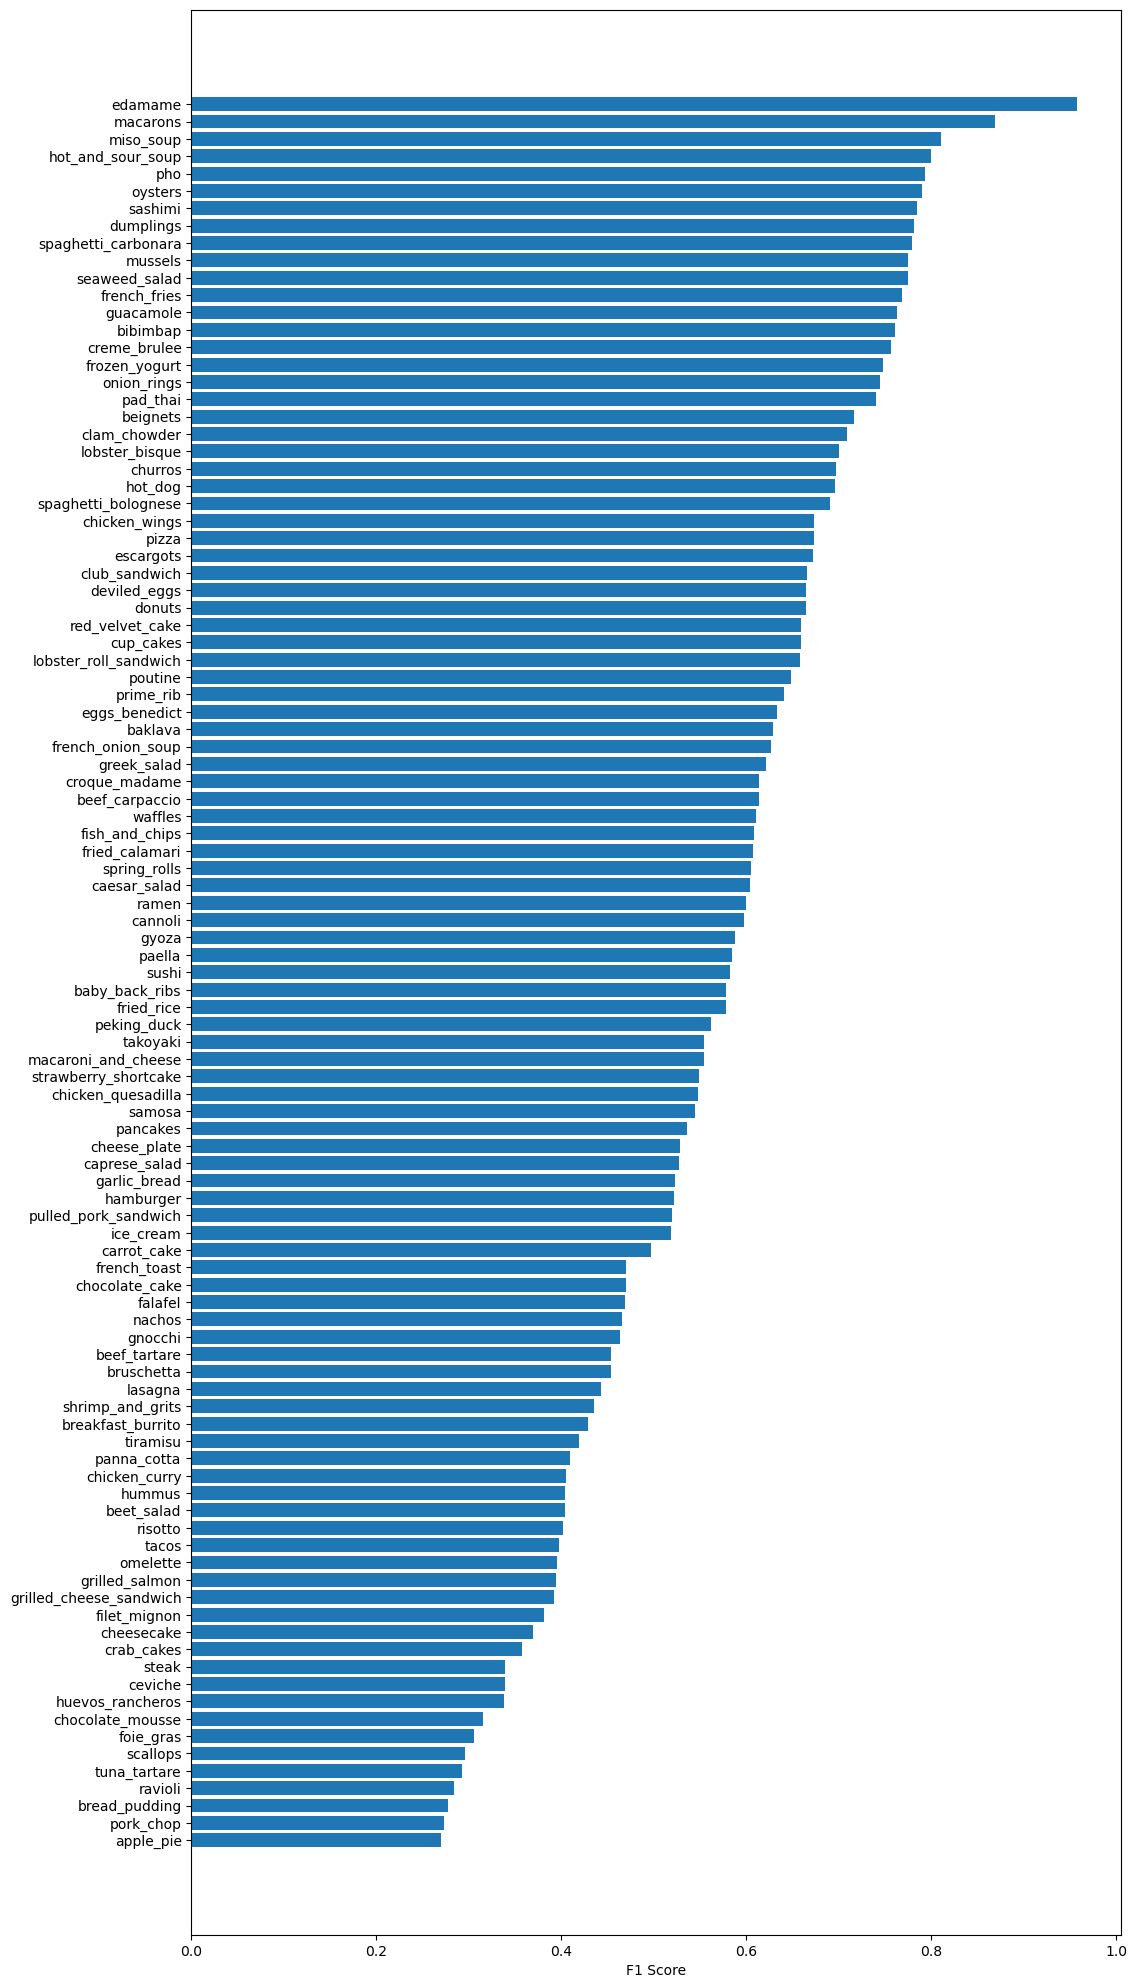

In [46]:
fig, ax = plt.subplots(figsize = (12,25))
scores = ax.barh(range(len(f1_scores)), f1_scores["F1 Score"].values)
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(f1_scores["class_names"].values)
ax.set_xlabel("F1 Score")
ax.invert_yaxis()
plt.show()

In [47]:
#defining a function to load and prepare a custom image to be fed as input to our model to get a prediction
def load_and_prep_image(filename, img_shape = 224, scale = True):
  '''Reads in an image from a file and turns it into a tensor and reshapes it into a specified shape
  (img_shape, img_shape, colour_channels = 3)

  Args:
  filename (str) = path to the target image
  img_shape (int) = size of the target image
  scale (bool) = Whether to rescale the pixelcolour values from 0-255 to 0-1

  Returns:
  Image tensor of the shape (img_shape, img_shape, colour_channels = 3)
  '''
  image = tf.io.read_file(filename)
  img = tf.io.decode_image(image, channels = 3)
  img = tf.image.resize(img, [img_shape, img_shape])
  if scale:
    img = img/255.0
    return img
  else:
    return img

1/1 [==============================] - 0s 160ms/step


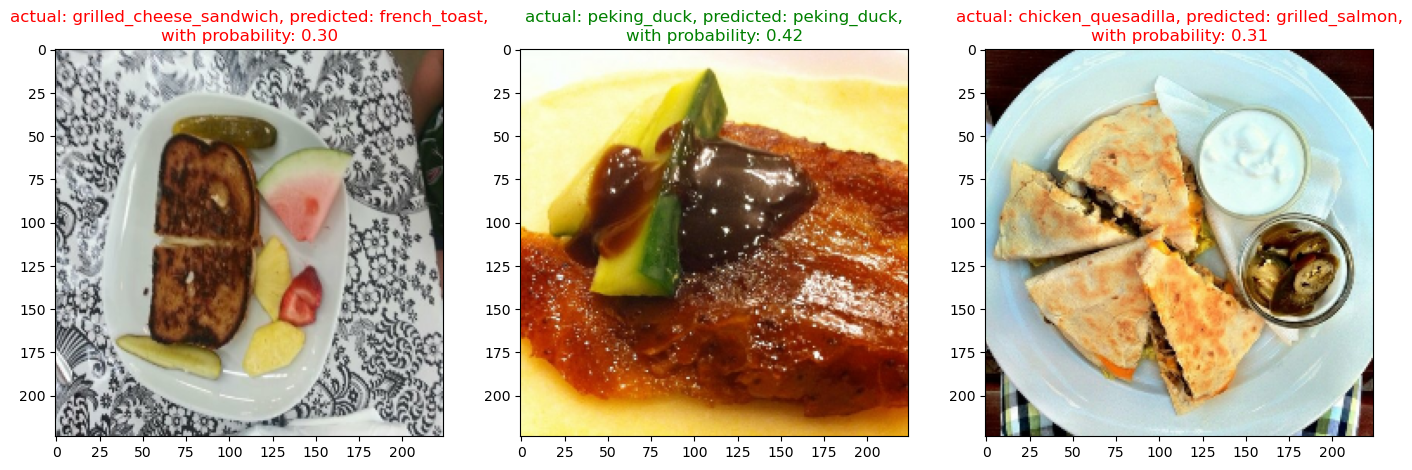

In [48]:
#make predictions on a series of random images
import os
import random
plt.figure(figsize = (17,10))
for i in range(3):
  #first, we pick a class for which we will make the prediction
  class_name = random.choice(test_data.class_names)
  #os.listdir() returns a list of all the files in the directory and then
  #random.choice() picks a random element out of the list elements
  filename = random.choice(os.listdir(f"101_food_classes_10_percent/test/{class_name}"))
  filepath = "101_food_classes_10_percent/test/" + class_name + "/" + filename
  img = load_and_prep_image(filepath, scale = False, img_shape = 224)
  pred_prob = model.predict(tf.expand_dims(img, axis = 0))   #receive the prediction. We must expand dims because of model's
  #expected input tensor shape
  pred = pred_prob.argmax()  #returns the index with the maximum value
  pred_class = test_data.class_names[pred]

  #plotting the image
  plt.subplot(1,3,i+1)
  plt.imshow(img/255.0)   #because the valid range is 0.0-1.0 for floats and 0-255 for integers. Since we have a tensor with floats
  if class_name == pred_class:
    title_color = "g"
  else:
    title_color = "r"
  plt.title(f"actual: {class_name}, predicted: {pred_class},\nwith probability: {pred_prob.max():.2f}", c = title_color)
  plt.axis = False
